In [2]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import math
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

In [4]:
go_sales = sqlite3.connect('/Users/pep/Downloads/Great_Outdoors_Data_SQLite/go_sales.sqlite')

order_header = pd.read_sql_query("SELECT * FROM order_header;", go_sales)
order_details = pd.read_sql_query("SELECT * FROM order_details;", go_sales)

In [5]:
order_details.drop('TRIAL879', axis=1)
order_header.drop('TRIAL885', axis=1)

,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE
0,1153,Ultra Sports,4,6,50,18,2020-04-14,7
1,1154,Ultra Sports,4,6,50,18,2020-10-01,4
2,1155,Ultra Sports,5,65,49,18,2020-04-21,7
3,1156,Ultra Sports,5,65,49,18,2020-09-09,5
4,1157,Ultra Sports,6,66,50,18,2020-04-10,2
...,...,...,...,...,...,...,...,...
5355,9475,Preben's T°y,338,329,29,15,2020-01-13,4
5356,9476,Preben's T°y,336,327,29,15,2021-01-02,5
5357,9477,Preben's T°y,338,329,29,15,2021-01-18,2
5358,9478,Preben's T°y,336,327,27,15,2022-01-15,7


In [6]:
full_order = pd.merge(order_details, order_header, on='ORDER_NUMBER')
full_order['UNIT_SALE_PRICE'] = full_order['UNIT_SALE_PRICE'].astype(float)
full_order['UNIT_PRICE'] = full_order['UNIT_PRICE'].astype(float)
full_order['UNIT_COST'] = full_order['UNIT_COST'].astype(float)

product = pd.read_sql_query("SELECT * FROM product", go_sales)
product_type = pd.read_sql_query("SELECT * FROM product_type;", go_sales)
product_line = pd.read_sql_query("SELECT * FROM product_line;", go_sales)

product_line_lookup = pd.merge(product, product_type, on='PRODUCT_TYPE_CODE')
product_line_lookup = pd.merge(product_line_lookup, product_line, on='PRODUCT_LINE_CODE')
product_line_lookup = product_line_lookup.loc[:,['PRODUCT_NUMBER', 'PRODUCT_LINE_EN']]

product_line_dummies = pd.get_dummies(product_line_lookup['PRODUCT_LINE_EN'])

product_line_lookup = product_line_lookup.drop(['PRODUCT_LINE_EN'], axis=1)
product_line_lookup = pd.concat([product_line_dummies, product_line_lookup], axis=1)

sales_profit_data = full_order.groupby('SALES_BRANCH_CODE').aggregate('sum')
sales_profit_data = sales_profit_data[['QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE']]

sales_product_data = pd.merge(full_order, product_line_lookup, on='PRODUCT_NUMBER')
sales_product_data = sales_product_data[['SALES_BRANCH_CODE', 'Camping Equipment', 'Golf Equipment', 'Mountaineering Equipment', 'Outdoor Protection', 'Personal Accessories']]
sales_product_data = sales_product_data.groupby('SALES_BRANCH_CODE').aggregate(np.mean)



/var/folders/2j/wmcmgy653bjc83jbqblntwnh0000gn/T/ipykernel_935/3336426330.py:24: FutureWarning: The provided callable <function mean at 0x10bec1760> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sales_product_data = sales_product_data.groupby('SALES_BRANCH_CODE').aggregate(np.mean)


In [7]:
table = sales_profit_data[['QUANTITY', 'UNIT_SALE_PRICE']]
df = pd.get_dummies(table)
table = pd.concat([table, df], axis=1)
table

,QUANTITY,UNIT_SALE_PRICE,QUANTITY,UNIT_SALE_PRICE
SALES_BRANCH_CODE,,,,
13,102648,188463.46,102648,188463.46
14,116778,206523.20,116778,206523.20
15,158062,517067.65,158062,517067.65
17,73848,88668.11,73848,88668.11
18,171852,324804.56,171852,324804.56
19,88444,321688.92,88444,321688.92
20,76848,342898.94,76848,342898.94
21,83110,403109.89,83110,403109.89
22,33550,168475.23,33550,168475.23


In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
prediction_results = kmeans.fit_predict(df)
prediction_results

kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns={i : f'{df.columns[i]}'})

kmeans_centra

,QUANTITY,UNIT_SALE_PRICE
0,84293.250000,224765.831250
1,117837.714286,378810.968571
2,51601.000000,112020.036667
3,58076.857143,177952.921429


In [9]:
for src_index, _ in df.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df

Afstand van bronindex 13 tot...
	Centrumindex 0:
		102648 - 84293.25 = 18354.75
		188463.46 - 224765.83125 = -36302.37125
	Totale euclidische som: 1654759005.9353263
	Euclidische afstand: 40678.729158312286
------------------------------------------------
	Centrumindex 1:
		102648 - 117837.71428571429 = -15189.71428571429
		188463.46 - 378810.96857142856 = -190347.50857142857
	Totale euclidische som: 36462901439.43171
	Euclidische afstand: 190952.61569151576
------------------------------------------------
	Centrumindex 2:
		102648 - 51601.0 = 51047.0
		188463.46 - 112020.03666666668 = 76443.42333333331
	Totale euclidische som: 8449393179.919208
	Euclidische afstand: 91920.58082888297
------------------------------------------------
	Centrumindex 3:
		102648 - 58076.857142857145 = 44571.142857142855
		188463.46 - 177952.92142857146 = 10510.538571428537
	Totale euclidische som: 2097058196.6533234
	Euclidische afstand: 45793.6479945999
------------------------------------------------
{0:

,QUANTITY,UNIT_SALE_PRICE,Centrum
SALES_BRANCH_CODE,,,
13,102648,188463.46,0.0
14,116778,206523.20,0.0
15,158062,517067.65,1.0
17,73848,88668.11,2.0
18,171852,324804.56,1.0
19,88444,321688.92,1.0
20,76848,342898.94,1.0
21,83110,403109.89,1.0
22,33550,168475.23,3.0


<function matplotlib.pyplot.show(close=None, block=None)>

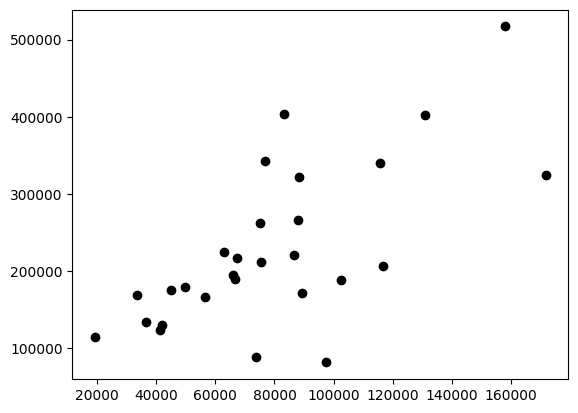

In [10]:
plt.scatter(df['QUANTITY'], df['UNIT_SALE_PRICE'], color = 'k')
plt.show

In [11]:
df.groupby('Centrum', as_index= False)['Centrum'].count()

,Centrum
0,8
1,7
2,6
3,7


In [12]:
kmeans = KMeans(n_clusters= 5, random_state=42)
prediction_results = kmeans.fit_predict(sales_product_data)
prediction_results

array([4, 4, 2, 2, 4, 3, 2, 3, 4, 4, 0, 1, 1, 2, 0, 3, 2, 1, 1, 1, 3, 3,
       2, 2, 2, 4, 2, 4], dtype=int32)

In [13]:
sales_product_data['Centrum'] = prediction_results
sales_product_data

,Camping Equipment,Golf Equipment,Mountaineering Equipment,Outdoor Protection,Personal Accessories,Centrum
SALES_BRANCH_CODE,,,,,,
13,0.409370,0.123656,0.132873,0.133641,0.200461,4
14,0.377478,0.155432,0.161776,0.096749,0.208565,4
15,0.411430,0.085079,0.213085,0.119214,0.171192,2
17,0.383126,0.042877,0.237898,0.106501,0.229599,2
18,0.401382,0.178628,0.106326,0.117491,0.196172,4
19,0.532534,0.084760,0.048373,0.140839,0.193493,3
20,0.391703,0.076419,0.253712,0.086463,0.191703,2
21,0.468878,0.087633,0.142097,0.112203,0.189189,3
22,0.405076,0.165482,0.081218,0.148223,0.200000,4


In [14]:
sales_product_data.groupby('Centrum', as_index= False)['Centrum'].count()

,Centrum
0,2
1,5
2,9
3,5
4,7
